In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from collections import Counter
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform

In [2]:
df = pd.read_csv('FINAL_FINAL.csv')

#taking Quantitative Vars
df = df[[ 'hours category', 'age_at_race', 'Elevation gain', 'Finishing Position', 'distance']]
df.dropna(inplace=True)
df = df.astype(int)


df.to_csv('Clustering_data.csv', index = False)

#Pulling Label
dfLabel = df['hours category']
df=df.drop(['hours category'], axis=1)




In [3]:
#### Applying kmeans to PCA with 2 elements

scaler = StandardScaler()
df = scaler.fit_transform(df)

MyPCA=PCA(n_components=2)

# Project the original data into the PCA space
PCAResult=MyPCA.fit_transform(df)

print("The eigenvalues:", MyPCA.explained_variance_)
print("The relative eigenvalues are:",MyPCA.explained_variance_ratio_)
print("Total Explained Variance with 2 components:",sum(MyPCA.explained_variance_ratio_))




The eigenvalues: [1.64942873 1.13362964]
The relative eigenvalues are: [0.41234857 0.28340149]
Total Explained Variance with 2 components: 0.69575005546726


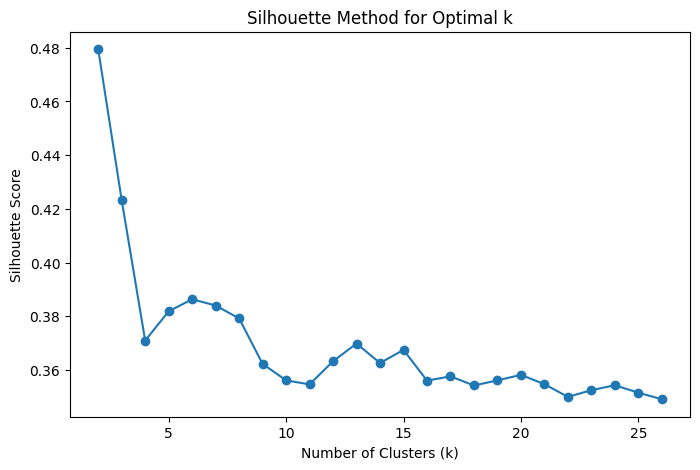

In [5]:
### Finding PCA Optimal K with silhoutte score 

silhouette_scores = []
k_val = range(2,27)  
for k in k_val:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(PCAResult)
    score = silhouette_score(PCAResult, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_val, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()

[]


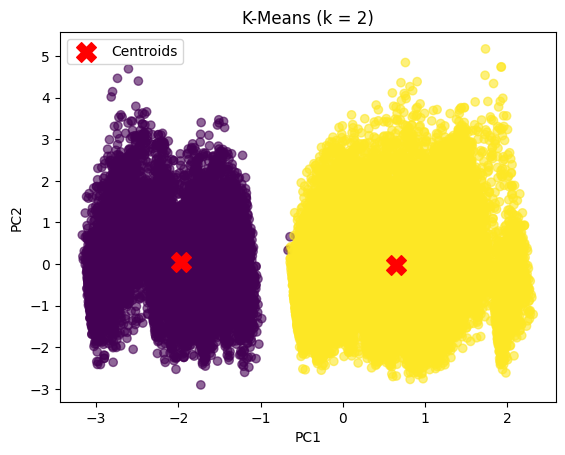

In [142]:

# Apply K-Means clustering = 2, 6, 13
print(silhouette_scores)

k = 2  # Number of clusters from silhoutte score - ADJUST FOR DIFFERENT GRAPHS
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(PCAResult)

# Get cluster centers and labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_


# Plot the clustered data
plt.scatter(PCAResult[:, 0], PCAResult[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label="Centroids")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means (k = 2)')
plt.legend()
plt.show()

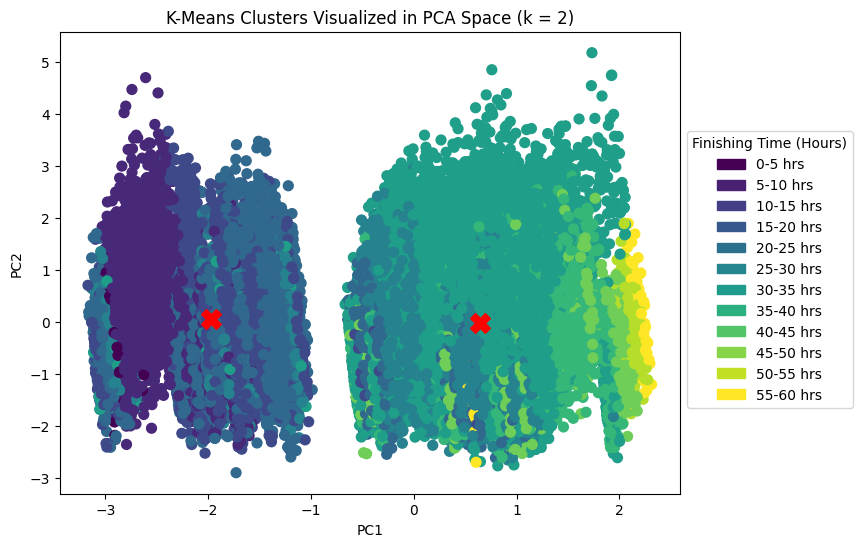

In [149]:

# Adjust K value for different outputs
k = 2

# Perform K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(PCAResult)

# Create a DataFrame with PCA results and cluster labels
df_clusters = pd.DataFrame(PCAResult, columns=['PC1', 'PC2'])
df_clusters['label'] = dfLabel  # Original labels (finishing times)

centers = kmeans.cluster_centers_

# Define custom hour range labels
custom_labels = {
    0: "0-5 hrs", 
    1: "5-10 hrs", 
    2: "10-15 hrs", 
    3: "15-20 hrs", 
    4: "20-25 hrs",
    5: "25-30 hrs",
    6: "30-35 hrs",
    7: "35-40 hrs",
    8: "40-45 hrs",
    9: "45-50 hrs",
    10: "50-55 hrs",
    11: "55-60 hrs"
}

# Create the plot
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("viridis")

scatter = plt.scatter(df_clusters['PC1'], df_clusters['PC2'], 
                      c=df_clusters['label'], cmap=cmap, s=50)


plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label="Centroids")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clusters Visualized in PCA Space (k = 2)')
legend_patches = [mpatches.Patch(color=cmap(i / (len(custom_labels)-1)), label=custom_labels[i]) for i in custom_labels]
plt.legend(handles=legend_patches, title="Finishing Time (Hours)", loc='upper left', bbox_to_anchor=(1.0, 0.8))
plt.show()


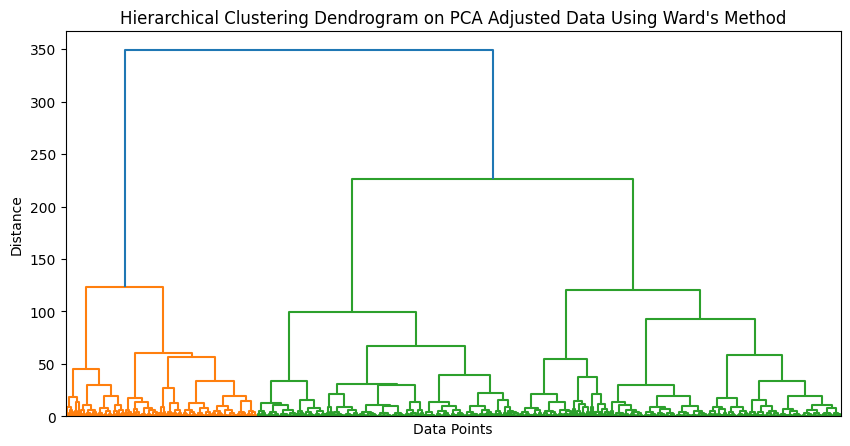

In [6]:
########### Hierarchical Clustering


linkage_matrix = linkage(PCAResult, method='ward')  # Using Ward's method which minimizes the variance with in cllusters

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, no_labels = True)
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram on PCA Adjusted Data Using Ward's Method")
plt.show()

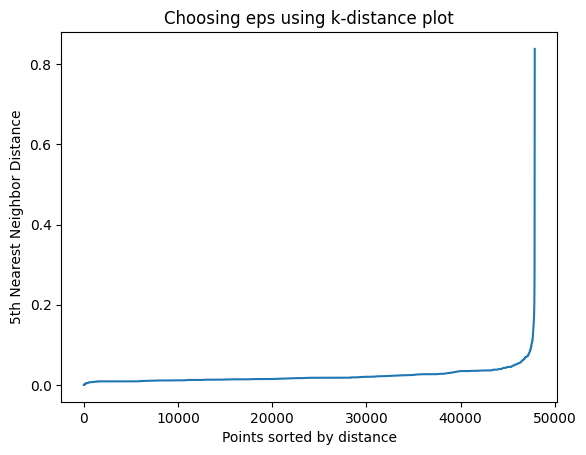

In [93]:
############## DBSCAN

nn = NearestNeighbors(n_neighbors=5).fit(PCAResult)
distances, _ = nn.kneighbors(PCAResult)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Choosing eps using k-distance plot")
plt.show()

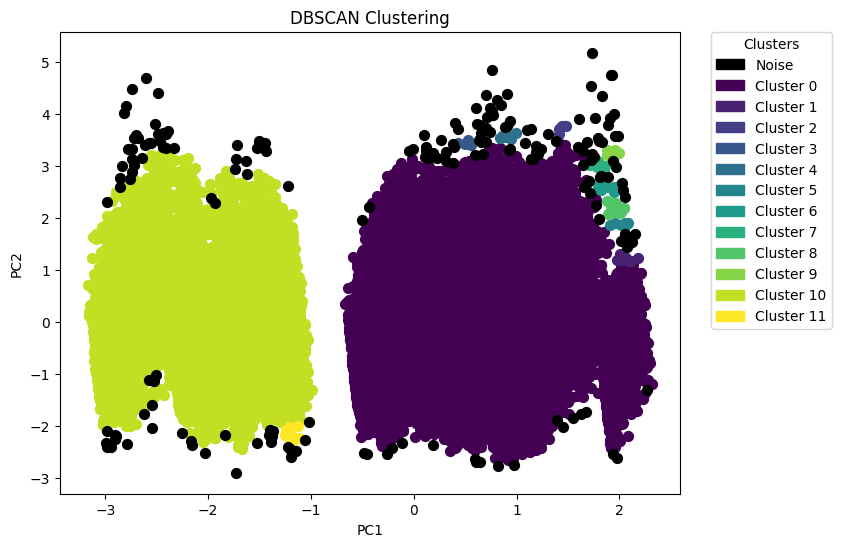

Number of clusters found: 12
Number of noise points: 198
Cluster distribution: Counter({np.int64(0): 35844, np.int64(10): 11736, np.int64(-1): 198, np.int64(8): 13, np.int64(11): 13, np.int64(6): 10, np.int64(1): 9, np.int64(5): 7, np.int64(7): 7, np.int64(9): 7, np.int64(2): 6, np.int64(4): 6, np.int64(3): 5})


In [147]:

# Run DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(PCAResult)

# Plot the results
plt.figure(figsize=(8, 6))

cmap = plt.get_cmap("viridis")

unique_labels = set(labels)

# Plot each cluster separately
for cluster in unique_labels:
    idx = labels == cluster
    color = 'black' if cluster == -1 else cmap(cluster / max(unique_labels - {-1}))  # Noise is black
    plt.scatter(PCAResult[idx, 0], PCAResult[idx, 1], c=[color], s=50, label=f"Cluster {cluster}" if cluster != -1 else "Noise")


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN Clustering")
legend_patches = [mpatches.Patch(color='black', label="Noise")]  # Noise label
for cluster in sorted(unique_labels - {-1}):  # Exclude noise (-1)
    legend_patches.append(mpatches.Patch(color=cmap(cluster / max(unique_labels - {-1})), label=f"Cluster {cluster}"))
plt.legend(handles=legend_patches, title="Clusters", loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

# Compute cluster statistics
num_clusters = len(set(labels) - {-1})  # Remove noise label (-1)
print(f"Number of clusters found: {num_clusters}")

num_noise_points = np.sum(labels == -1)
print(f"Number of noise points: {num_noise_points}")

cluster_counts = Counter(labels)
print("Cluster distribution:", cluster_counts)
